# CSC321 Project 4 - Text Autoencoder (RNN) to generate news headlines

**Valerie June Loka (100 4900 495) lokavale**

**Gabrielle Ong (100 4634 791) onggabr1**

---

**Deadline**: Thursday, April. 2, by 9pm

**Submission**: 
If you are using Google Colab or Jupyter Notebook,
the easiest way to submit the assignment is to submit a PDF export of the completed notebook. 
If you are using Python, please submit a PDF file containing your code, written solutions,
and any outputs that we are using to evaluate your work.

**Late Submission**: Please see the syllabus for the late submission criteria.

This time, we're back to the application of deep learning to natural language processing.
We will be working with a subset of Reuters news headlines that are collected over 15 months,
covering all of 2019, plus a few months in 2018 and in a few months of this year.

In particular, we will be building an **autoencoder** of news headlines. The idea is similar
to the kind of image autoencoder we built in lecture: we will have an **encoder** that
maps a news headline to a vector embedding, and then a **decoder** that reconstructs
the news headline. Both our encoder and decoder networks will be Recurrent Neural Networks,
so that you have a chance to practice building

- a neural network that takes a sequence as an input
- a neural network that generates a sequence as an output

This project is organized as follows:

- Question 1. Exploring the data
- Question 2. Building the autoencoder
- Question 3. Training the autoencoder using *data augmentation*
- Question 4. Analyzing the embeddings (interpolating between headlines)

Furthermore, we'll be introducing the idea of **data augmentation** for improving of
the robustness of the autoencoder, as proposed by Shen et al [1].

[1] Shen et al (2019) "Educating Text Autoencoders: Latent Representation Guidance via Denoising" https://arxiv.org/pdf/1905.12777.pdf

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

In [ ]:
ct = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3,
stride=2, padding=1, output_padding=1)

print(ct(torch.zeros((1, 1, 8, 8))).shape)
print(ct(torch.zeros((1, 1, 4, 4))).shape)

torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])


## Question 1

Download the files `reuters_train.txt` and `reuters_valid.txt`, and upload them to Google Drive.

Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/CSC321/reuters_train.txt' # Done
valid_path = '/content/gdrive/My Drive/CSC321/reuters_valid.txt' # Done

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


As promised in previous lecture, we will be using PyTorch's `torchtext` utilities to help us load, process,
and batch the data. We'll be using a `TabularDataset` to load our data, which works well on structured
CSV data with fixed columns (e.g. a column for the sequence, a column for the label). Our tabular dataset
is even simpler: we have no labels, just some text. So, we are treating our data as a table with one field
representing our sequence.

In [ ]:
import torchtext

# Tokenization function to separate a headline into words
def tokenize_headline(headline):
    """Returns the sequence of words in the string headline. We also
    prepend the "<bos>" or beginning-of-string token, and append the
    "<eos>" or end-of-string token to the headline.
    """
    return ("<bos> " + headline + " <eos>").split()

# Data field (column) representing our *text*.
text_field = torchtext.data.Field(
    sequential=True,            # this field consists of a sequence
    tokenize=tokenize_headline, # how to split sequences into words
    include_lengths=True,       # to track the length of sequences, for batching
    batch_first=True,           # similar to batch_first=True in nn.RNN demonstrated in lecture
    use_vocab=True)             # to turn each character into an integer index
train_data = torchtext.data.TabularDataset(
    path=train_path,                # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (we have only one)

### Part (a) -- 2 points

Draw histograms of the number of words per headline in our training set.
Excluding the `<bos>` and `<eos>` tags in your computation.
Explain why we would be interested in such histograms.

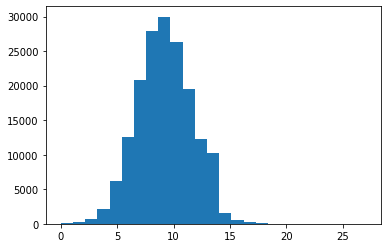

'\n===EXPLANATION===\nWe want to know roughly how many words per headline,\nto have an idea of how many hidden units are required.\nIf the sentence is too long, \nwe may decide to use attention based encoders and decoders.\n'

In [ ]:
# Include your histogram and your written explanations

# Here is an example of how to plot a histogram in matplotlib:
# plt.hist(np.random.normal(0, 1, 40), bins=20)

# x-axis = number of words in a headline
# y-axis = frequency of a specific number of words in a headline

values_hist = []

for t in train_data:
  values_hist.append(len(t.title[1:len(t.title)-1])-2) # -2 to exclude bos, eos

bin_value = len(set(values_hist))
plt.hist(values_hist, bins=bin_value)
plt.show()

# print(bin_value)

# Here are some sample code that uses the train_data object:
# print(train_data[0].title)
# for example in train_data:
#     print(example.title)
#     break

"""
===EXPLANATION===
We want to know roughly how many words per headline,
to have an idea of how many hidden units are required.
If the sentence is too long, 
we may decide to use attention based encoders and decoders.
"""

### Part (b) -- 2 points

How many distinct words appear in the training data?
Exclude the `<bos>` and `<eos>` tags in your computation.

In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

# You might find the python class Counter from the collections package useful
# from collections import Counter
# num_distinct = len(list(Counter(train_data).keys()))
# print("number of distinct words: ", num_distinct)
from collections import Counter
words_list = []
for seq in train_data:
  for word in seq.title[1:len(seq.title)-1]: # excludes bos eos
    words_list.append(word)

distinct_words = list(Counter(words_list).keys())
num_distinct = len(distinct_words)
print("number of distinct words: ", num_distinct)

number of distinct words:  51298


### Part (c) -- 2 points

The distribution of *words* will have a long tail, meaning that there are some words
that will appear very often, and many words that will appear infrequently. How many words
appear exactly once in the training set? Exactly twice?

In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

word_occ_list = list(Counter(words_list).values())
words_once = word_occ_list.count(1)
words_twice = word_occ_list.count(2)
print("number of words appearing once: ", words_once)
print("number of words appearing twice: ", words_twice)

number of words appearing once:  19854
number of words appearing twice:  7193


### Part (d) -- 2 points

Explain why we may wish to replace these infrequent
words with an `<unk>` tag, instead of learning embeddings for these rare words.
(Hint: Consider words in the validation set that might not appear in training)

In [ ]:
# Include your explanation here
"""
===EXPLANATION===
Since these words are infrequent, there's almost no point in learning word 
embeddings for them, since there is little to no pattern in the training set.
So we can just consider them negligible in the training set and 
replace them with <unk>.

Through training, we are able to get an embedding for <unk> for rare words,
so on the validation set, we can also generate the <unk> tag for rare words
that did not appear in training. 
"""

"\n===EXPLANATION===\nSince these words are infrequent, there's almost no point in learning word \nembeddings for them, since there is little to no pattern in the training set.\nSo we can just consider them negligible in the training set and \nreplace them with <unk>.\n\nThrough training, we are able to get an embedding for <unk> for rare words,\nso on the validation set, we can also generate the <unk> tag for rare words\nthat did not appear in training. \n"

### Part (e) -- 2 points

We will only model the top 9995 words in the training set, excluding the tags
`<bos>`, `<eos>`, and other possible tags we haven't mentioned yet
(including those, we will have a vocabulary size of exactly 10000 tokens).

What percentage of word occurrences will be supported? Alternatively, what percentage
of word occurrences in the training set will be set to the `<unk>` tag?

In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

# Sanity Check:
# print(Counter(words_list).most_common(10))
# [('to', 58452), (',', 43088), ('in', 38538), ("'s", 34580), ('_num_', 31340), 
#  (':', 28052), ('on', 24794), ('of', 22895), ('for', 22163), ('u.s.', 19320)]

freq_top_words = [freq for word, freq in Counter(words_list).most_common(9995)]
supported = sum(freq_top_words)
percent_supported = supported / len(words_list) * 100
percent_unsupported = 100 - percent_supported
print("percentage of words occurrences supported: ", percent_supported, "%")
print("percentage of words set to <unk>: ", percent_unsupported, "%")

percentage of words occurrences supported:  93.97857393100142 %
percentage of words set to <unk>:  6.021426068998579 %


Our `torchtext` package will help us keep track of our list of unique words, known
as a **vocabulary**. A vocabulary also assigns a unique integer index to each word.
You can interpret these indices as sparse representations of one-hot vectors.

In [ ]:
# Build the vocabulary based on the training data. The vocabulary
# can have at most 9997 words (9995 words + the <bos> and <eos> token)
text_field.build_vocab(train_data, max_size=9997)

# This vocabulary object will be helpful for us
vocab = text_field.vocab
print(vocab.stoi["hello"]) # for instances, we can convert from string to (unique) index
print(vocab.itos[10])      # ... and from word index to string

# The size of our vocabulary is actually 10000
vocab_size = len(text_field.vocab.stoi)
print(vocab_size) # should be 10000

# The reason is that torchtext adds two more tokens for us:
print(vocab.itos[0]) # <unk> represents an unknown word not in our vocabulary
print(vocab.itos[1]) # <pad> will be used to pad short sequences for batching

0
on
10000
<unk>
<pad>


## Question 2

Building a text autoencoder is a little more complicated than an image autoencoder, so
we'll need to thoroughly understand the model that we want to build before actually building
our model. Note that the best and fastest way to complete this assignment is to spend a *lot*
of time upfront understanding the architecture. The explanations are quite dense, and you
might need to stop every sentence or two to understand what's going on.
You won't feel productive for a while since you won't be writing code,
but this initial investment will help you become more productive later on.
Understanding this architecture will also help you understand other machine learning
papers you might come across. So, take a deep breath, and let's do this!

Here is a diagram showing our desired architecture:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p4model.png" width="95%" />

There are two main components to the model: the **encoder** and the **decoder**.
As always with neural networks, we'll first describe how to make
**predictions** with of these components. Let's get started:

The **encoder** will take a sequence of words (a headline) as *input*, and produce an
embedding (a vector) that represents the entire headline. In the diagram above,
the vector ${\bf h}^{(7)}$ is the vector embedding containing information about 
the entire headline.  This portion is very similar
to the sentiment analysis RNN that we discussed in lecture (but without the fully-connected
layer that makes a prediction).

The **decoder** will take an embedding (in the diagram, the vector ${\bf h}^{(7)}$) as input,
and uses a separate RNN to **generate a sequence of words**. To generate a sequence of words,
the decoder needs to do the following:

1) Determine the previous word that was generated. This previous word will act as ${\bf x}^{(t)}$
   to our RNN, and will be used to update the hidden state ${\bf m}^{(t)}$. Since each of our
   sequences begin with the `<bos>` token, we'll set ${\bf x}^{(1)}$ to be the `<bos>` token.
2) Compute the updates to the hidden state ${\bf m}^{(t)}$ based on the previous hidden state
   ${\bf m}^{(t-1)}$ and ${\bf x}^{(t)}$. Intuitively, this hidden state vector ${\bf m}^{(t)}$
   is a representation of *all the words we still need to generate*.
3) We'll use a fully-connected layer to take a hidden state ${\bf m}^{(t)}$, and determine
   *what the next word should be*. This fully-connected layer solves a *classification problem*,
   since we are trying to choose a word out of $K=10000$ distinct words. As in a classification
   problem, the fully-connected neural network will compute a *probability distribution* over
   these 10,000 words. In the diagram, we are using ${\bf z}^{(t)}$ to represent the logits,
   or the pre-softmax activation values representing the probability distribution.
4) We will need to *sample* an actual word from this probability distribution ${\bf z}^{(t)}$.
   We can do this in a number of ways, which we'll discuss in question 3. For now, you can 
   imagine your favourite way of picking a word given a distribution over words.
5) This word we choose will become the next input ${\bf x}^{(t+1)}$ to our RNN, which is used
   to update our hidden state ${\bf m}^{(t+1)}$---i.e. to determine what are the remaining
   words to be generated.

We can repeat this process until we see an `<eos>` token generated, or until the generated
sequence becomes too long.

Unfortunately, we can't *train* this autoencoder in the way we just described. That is,
we can't just compare our generated sequence with our ground-truth sequence, and get
gradients. Both sequences are **discrete** entities, so we won't be able to compute
gradients at all! In particular, **sampling is a discrete process**, and so we won't be
able to back-propagate through any kind of sampling that we do.

You might wonder whether we can get away with computing gradients by comparing the
distributions ${\bf z}^{(t)}$ with the ground truth words at each time step. Like any
multi-class classification problem, we can represent the ground-truth words as a one-hot
vector, and use the cross-entropy loss.

In theory, we can do this. In practice, there are a few issues. One is that the generated
sequence might be longer or shorter than the actual sequence, meaning that there may
be more/fewer ${\bf z}^{(t)}$s than ground-truth words. Another more insidious issue
is that the **gradients will become very high-variance and unstable**, because
**early mistakes will easily throw the model off-track**. Early in training,
our model is unlikely to produce the right answer in step $t=1$, so the gradients
we obtain based on the other time steps will not be very useful.

At this point, you might have some ideas about "hacks" we can use to make training
work. Fortunately, there is one very well-established solution called
**teacher forcing** which we can use for training:
instead of *sampling* the next word based on ${\bf z}^{(t)}$, we will forgo sampling,
and use the **ground truth** ${\bf x}^{(t)}$ in the next step.

Here is a diagram showing how we can use **teacher forcing** to train our model:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p4model_tf.png" width="95%" />

We will use the RNN generator to compute the logits
${\bf z}^{(1)},{\bf z}^{(2)},  \cdots {\bf z}^{(T)}$. These distributions
can be compared to the ground-truth words using the cross-entropy loss.
The loss function for this model will be the sum of the losses across each $t$.
(This is similar to what we did in a pixel-wise prediction problem.)

We'll train the encoder and decoder model simultaneously. There are several components
to our model that contain tunable weights:

- The word embedding that maps a word to a vector representation.
  In theory, we could use GloVe embeddings, or initialize our parameters to
  GloVe embeddings. To prevent students who don't have Colab access
  from having to download a 1GB file, we won't do that.
  The word embedding component is represented with blue arrows in the diagram.
- The encoder RNN (which will use Gated Recurrent Units) that computes the
  embedding over the entire headline. The encoder RNN 
  is represented with black arrows in the diagram.
- The decoder RNN (which will also use Gated Recurrent Units) that computes
  hidden states, which are vectors representing what words are to be generated.
  The decoder RNN is represented with gray arrows in the diagram.
- The **projection MLP** (a fully-connected layer) that computes
  a distribution over the next word to generate, given a decoder RNN hidden
  state.

## Part (a) -- 10 pts

Complete the code for the AutoEncoder class below by:

1. Filling in the missing numbers in the `__init__` method using
   the parameters `vocab_size`, `emb_size`, and `hidden_size`. (4 points)
2. Complete the `forward` method, which uses teacher forcing
   and computes the logits $z^{(t)}$ of the reconstruction of
   the sequence. (4 points)

You should first try to understand the `encode` and `decode` methods,
which are written for you. The `encode` method mimics the discriminative
RNN we wrote in class for sentiment analysis.  The `decode` method is
a bit more challenging. You might want to scroll down to the
`sample_sequence` function to see how this function will be called.

You can (but don't have to) use the `encode` and `decode` method in
your `forward` method. In either case, be very careful of the input
that you feed into ether `decode` or to `self.decoder_rnn`.
Refer to the teacher-forcing diagram.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        """
        A text autoencoder. The parameters 
            - vocab_size: number of unique words/tokens in the vocabulary
            - emb_size: size of the word embeddings $x^{(t)}$
            - hidden_size: size of the hidden states in both the
                           encoder RNN ($h^{(t)}$) and the
                           decoder RNN ($m^{(t)}$)
        """
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size, # TODO
                                  embedding_dim=emb_size)  # TODO
        self.encoder_rnn = nn.GRU(input_size=emb_size, #TODO
                                  hidden_size=hidden_size, #TODO
                                  batch_first=True)
        self.decoder_rnn = nn.GRU(input_size=emb_size, #TODO
                                  hidden_size=hidden_size, #TODO
                                  batch_first=True)
        # fully-connect layer that outputs a distribution over
        # the next token, given the RNN output
        self.proj = nn.Linear(in_features=hidden_size, # TODO
                              out_features=vocab_size) # TODO

    def encode(self, inp):
        """
        Computes the encoder output given a sequence of words.
        """
        emb = self.embed(inp)
        out, last_hidden = self.encoder_rnn(emb)
        return last_hidden # Shape: (num_layers*directions, batch, hidden_size)

    def decode(self, inp, hidden=None):
        """
        Computes the decoder output given a sequence of words, and
        (optionally) an initial hidden state.
        """
        emb = self.embed(inp)
        out, last_hidden = self.decoder_rnn(emb, hidden)
        out_seq = self.proj(out)
        return out_seq, last_hidden

    def forward(self, inp):
        """
        Compute both the encoder and decoder forward pass
        given an integer input sequence inp with shape [batch_size, seq_length],
        with inp[a,b] representing the (index in our vocabulary of) the b-th word
        of the a-th training example.

        This function should return the logits $z^{(t)}$ in a tensor of shape
        [batch_size, seq_length - 1, vocab_size], computed using *teaching forcing*.

        The (seq_length - 1) part is not a typo. If you don't understand why
        we need to subtract 1, refer to the teacher-forcing diagram above.
        """
        # TODO
        encoder_hidden = self.encode(inp)
        out_seq, decoder_hidden = self.decode(inp, encoder_hidden)
        return out_seq, decoder_hidden

### Part (b) -- 5 pts

To check that your model is set up correctly, we'll train our AutoEncoder
neural network for at least 300 iterations to memorize this sequence:

In [ ]:
headline = train_data[42].title
print(headline)
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).long().unsqueeze(0)

['<bos>', 'zambian', 'president', 'swears', 'in', 'new', 'army', 'chief', '<eos>']


We are looking for the way that you set up your loss function
corresponding to the figure above.
**Be very careful of off-by-ones.**


Note that the Cross Entropy Loss expects a rank-2 tensor as its first
argument, and a rank-1 tensor as its second argument. You will
need to properly reshape your data to be able to compute the loss.

In [ ]:
model = AutoEncoder(vocab_size, 128, 128)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for it in range(300):

    # TODO
    optimizer.zero_grad()
    output, hidden = model(input_seq[:,:-1]) # take out <eos> from input
    target = input_seq[:,1:] # take out <bos> from target
    loss = criterion(output.reshape(-1, vocab_size), # reshape to 2D tensor
                     target.reshape(-1))             # reshape to 1D tensor
    loss.backward()
    optimizer.step()
    
    if (it+1) % 20 == 0:
        print("[Iter %d] Loss %f" % (it+1, float(loss)))

[Iter 20] Loss 3.496940
[Iter 40] Loss 0.296341
[Iter 60] Loss 0.068585
[Iter 80] Loss 0.041055
[Iter 100] Loss 0.030894
[Iter 120] Loss 0.024815
[Iter 140] Loss 0.020527
[Iter 160] Loss 0.017315
[Iter 180] Loss 0.014831
[Iter 200] Loss 0.012861
[Iter 220] Loss 0.011281
[Iter 240] Loss 0.010005
[Iter 260] Loss 0.008953
[Iter 280] Loss 0.008070
[Iter 300] Loss 0.007321


### Part (c) -- 2 pt

Once you are satisfied with your model, encode your input using
the RNN encoder, and sample some sequences from the decoder. The 
sampling code is provided to you, and performs the computation
from the first diagram (without teacher forcing).

Note that we are sampling from a multi-nomial distribution described
by the logits $z^{(t)}$. For example, if our distribution is [80%, 20%]
over a vocabulary of two words, then we will choose the first word
with 80% probability and the second word with 20% probability.

Call `sample_sequence` at least 5 times, with the default temperature
value. Make sure to include the generated sequences in your PDF
report.

In [ ]:
def sample_sequence(model, hidden, max_len=20, temperature=1):
    """
    Return a sequence generated from the model's decoder
        - model: an instance of the AutoEncoder model
        - hidden: a hidden state (e.g. computed by the encoder)
        - max_len: the maximum length of the generated sequence
        - temperature: described in Part (d)
    """
    # We'll store our generated sequence here
    generated_sequence = []
    # Set input to the <BOS> token
    inp = torch.Tensor([text_field.vocab.stoi["<bos>"]]).long()
    for p in range(max_len):
        # compute the output and next hidden unit
        output, hidden = model.decode(inp.unsqueeze(0), hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted word to string and use as next input
        word = text_field.vocab.itos[top_i]
        # Break early if we reach <eos>
        if word == "<eos>":
            break
        generated_sequence.append(word)
        inp = torch.Tensor([top_i]).long()
    return generated_sequence

# Your solutions go here
hidden = model.encode(input_seq)
print(sample_sequence(model, hidden))
print(sample_sequence(model, hidden))
print(sample_sequence(model, hidden))
print(sample_sequence(model, hidden))
print(sample_sequence(model, hidden))

['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']


### Part (d) -- 3 pt

The multi-nomial distribution can be manipulated using the `temperature`
setting. This setting can be used to make the distribution "flatter" (e.g.
more likely to generate different words) or "peakier" (e.g. less likely
to generate different words).

Call `sample_sequence` at least 5 times each for at least 3 different
temperature settings (e.g. 1.5, 2, and 5). Explain why we generally
don't want the temperature setting to be too **large**.

In [ ]:
# Include the generated sequences and explanation in your PDF report.
print("\nTemperature = 1.5:")
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))

print("\nTemperature = 2:")
print(sample_sequence(model, hidden, temperature=2))
print(sample_sequence(model, hidden, temperature=2))
print(sample_sequence(model, hidden, temperature=2))
print(sample_sequence(model, hidden, temperature=2))
print(sample_sequence(model, hidden, temperature=2))

print("\nTemperature = 5:")
print(sample_sequence(model, hidden, temperature=5))
print(sample_sequence(model, hidden, temperature=5))
print(sample_sequence(model, hidden, temperature=5))
print(sample_sequence(model, hidden, temperature=5))
print(sample_sequence(model, hidden, temperature=5))

"""
===EXPLANATION===
The temperature parameter manipulates the softmax outputs -
A large temperature makes the probability of each token more even so we end up
with more random and diverse sample, with potentially more mistakes.
"""


Temperature = 1.5:
['y', 'struggle', 'zambian', 'president', 'swears', 'in', 'new', 'army', 'dementia', 'chief', 'kills', 'jr.', 'flowing', 'schlumberger', 'hide', 'valuation', 'swears', 'limited', 'injection', 'complaint']
['zambian', '18,000', 'right', 'mall', 'torch', 'approval', 'bloody', 'large', 'in', 'new', 'army', 'mate', '_num_-california', 'boon', 'amend', 'cost', '_num_-india', 'other', 'tornadoes', 'hdfc']
['crowds', 'freeze', 'lgbt', 'army', 'hughes', 'repayment', 'accusers', 'developed', 'pledge', 'fueled', 'bofa', 'islamists', 'wednesday', 'irish', 'atp', 'temper', 'slovenia', 'threatened', 'warming', 'euros']
['zambian', 'jedi', 'president', 'swears', 'skip', 'new', 'army', 'chief']
['kudlow', 'hear', 'auto', 'grips', 'racism', '_num_-starbucks', '_num_-week', 'voluntary', 'fears', 'refinery', 'new', 'army', 'chief', '_num_-hundreds', 'showed', 'upside', 'tweet', 'operate', 'defences', '_num_-sweden']

Temperature = 2:
['easily', 'bomber', 'hardliners', 'expect', 'bagh

'\n===EXPLANATION===\nThe temperature parameter manipulates the softmax outputs -\nA large temperature makes the probability of each token more even so we end up\nwith more random and diverse sample, with potentially more mistakes.\n'

## Question 3

It turns out that getting good results from a text auto-encoder is very difficult,
and that it is very easy for our model to **overfit**. We have discussed several methods
that we can use to prevent overfitting, and we'll introduce one more today:
**data augmentation**.

The idea behind data augmentation is to artificially increase the number of training
examples by "adding noise" to the image. For example, during AlexNet training,
the authors randomly cropped $224\times 224$
regions of a $256 \times 256$ pixel image to increase the amount of training data.
The authors also flipped the image left/right (but not up/down---why?).
Machine learning practitioners can also add Gaussian noise to the image.

When we use data augmentation to train an *autoencoder*, we typically to only add
the noise to the input, and expect the reconstruction to be *noise free*.
This makes the task of the autoencoder even more difficult. An autoencoder trained
with noisy inputs is called a **denoising auto-encoder**. For simplicity, we will
*not* build a denoising autoencoder today.

### Part (a) -- 3pt

Give three more examples of data augmentation techniques that we could use if
we were training an **image** autoencoder. What are different ways that we can
change our input?

In [ ]:
# Include your three answers
"""
1. Translate image in a direction
2. Rotate image
3. Alter intensities of RGB channels
"""

'\n1. Translate image in a direction\n2. Rotate image\n3. Alter intensities of RGB channels\n'

### Part (b) -- 2pt

We will add noise to our headlines using a few different techniques:

1. Shuffle the words in the headline, taking care that words don't end up too far from where they were initially
2. Drop (remove) some words 
3. Replace some words with a blank word (a `<pad>` token)
4. Replace some words with a random word 

The code for adding these types of noise is provided for you:

In [ ]:
def tokenize_and_randomize(headline,
                           drop_prob=0.1,  # probability of dropping a word
                           blank_prob=0.1, # probability of "blanking" out a word
                           sub_prob=0.1,   # probability of substituting a word with a random one
                           shuffle_dist=3): # maximum distance to shuffle a word
    """
    Add 'noise' to a headline by slightly shuffling the word order,
    dropping some words, blanking out some words (replacing with the <pad> token)
    and substituting some words with random ones.
    """
    headline = [vocab.stoi[w] for w in headline.split()]
    n = len(headline)
    # shuffle
    headline = [headline[i] for i in get_shuffle_index(n, shuffle_dist)]

    new_headline = [vocab.stoi['<bos>']]
    for w in headline:
        if random.random() < drop_prob:
            # drop the word
            pass
        elif random.random() < blank_prob:
            # replace with blank word
            new_headline.append(vocab.stoi["<pad>"])
        elif random.random() < sub_prob:
            # substitute word with another word
            new_headline.append(random.randint(0, vocab_size - 1))
        else:
            # keep the original word
            new_headline.append(w)
    new_headline.append(vocab.stoi['<eos>'])
    return new_headline

def get_shuffle_index(n, max_shuffle_distance):
    """ This is a helper function used to shuffle a headline with n words,
    where each word is moved at most max_shuffle_distance. The function does
    the following: 
       1. start with the *unshuffled* index of each word, which
          is just the values [0, 1, 2, ..., n]
       2. perturb these "index" values by a random floating-point value between
          [0, max_shuffle_distance]
       3. use the sorted position of these values as our new index
    """
    index = np.arange(n)
    perturbed_index = index + np.random.rand(n) * 3
    new_index = sorted(enumerate(perturbed_index), key=lambda x: x[1])
    return [index for (index, pert) in new_index]

Call the function `tokenize_and_randomize` 5 times on a headline of your
choice. Make sure to include both your original headline, and the five new
headlines in your report.

In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values
headline = " ".join(train_data[42].title[1:-1]) # exclude bos eos
print("Original: ")
print(headline)

print("\nNew: ")
str_lst = [vocab.itos[token] for token in tokenize_and_randomize(headline)]
print(" ".join(str_lst))

str_lst = [vocab.itos[token] for token in tokenize_and_randomize(headline)]
print(" ".join(str_lst))

str_lst = [vocab.itos[token] for token in tokenize_and_randomize(headline)]
print(" ".join(str_lst))

str_lst = [vocab.itos[token] for token in tokenize_and_randomize(headline)]
print(" ".join(str_lst))

str_lst = [vocab.itos[token] for token in tokenize_and_randomize(headline)]
print(" ".join(str_lst))

Original: 
zambian president swears in new army chief

New: 
<bos> zambian <pad> president new <pad> <pad> chief <eos>
<bos> zambian swears president in army wilt chief <eos>
<bos> zambian president new army <pad> <eos>
<bos> president swears <pad> new <pad> lease <eos>
<bos> <pad> zambian in swears new army <pad> <eos>


### Part (c) -- 3 pt

The training code that we use to train the model is mostly provided for you. 
The only part we left blank are the parts from Q2(b). Complete the code,
and train a new AutoEncoder model for 1 epoch. You can train your model
for longer if you want, but training tend to take a long time,
so we're only checking to see that your training loss is trending down.

If you are using Google Colab, you can use a GPU for this portion.
Go to "Runtime" => "Change Runtime Type"  and set "Hardware acceleration" to GPU.
Your Colab session will restart.
You can move your model to the GPU by typing `model.cuda()`, and move
other tensors to GPU (e.g. `xs = xs.cuda()`). To move a model back to CPU,
type `model.cpu`. To move a tensor back, use `xs = xs.cpu()`. For training,
your model and inputs need to be on the *same device*.

[Iter 100] Loss 4.480561
[Iter 200] Loss 4.219703
[Iter 300] Loss 3.953588
[Iter 400] Loss 3.509284
[Iter 500] Loss 3.873543
[Iter 600] Loss 3.841098
[Iter 700] Loss 3.702840
[Iter 800] Loss 3.406767
[Iter 900] Loss 3.463033
[Iter 1000] Loss 3.729003
[Iter 1100] Loss 3.970057
[Iter 1200] Loss 3.054894
[Iter 1300] Loss 3.601360
[Iter 1400] Loss 3.471292
[Iter 1500] Loss 3.222801
[Iter 1600] Loss 2.974148
[Iter 1700] Loss 3.485328
[Iter 1800] Loss 3.481172
[Iter 1900] Loss 2.985933
[Iter 2000] Loss 3.136920
[Iter 2100] Loss 3.302219
[Iter 2200] Loss 2.936310
[Iter 2300] Loss 3.274471
[Iter 2400] Loss 3.311696
[Iter 2500] Loss 3.387685
[Iter 2600] Loss 3.250388


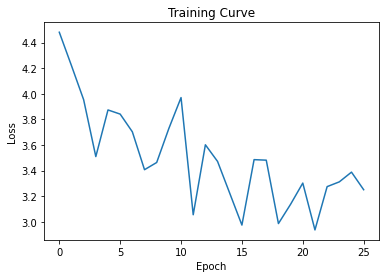

In [ ]:
def train_autoencoder(model, batch_size=64, learning_rate=0.001, num_epochs=1):
  model.cuda()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  losses = []
  for ep in range(num_epochs):
    # We will perform data augmentation by re-reading the input each time
    field = torchtext.data.Field(sequential=True,
                                tokenize=tokenize_and_randomize, # <-- data augmentation
                                include_lengths=True,
                                batch_first=True,
                                use_vocab=False, # <-- the tokenization function replaces this
                                pad_token=vocab.stoi['<pad>'])
    dataset = torchtext.data.TabularDataset(train_path, "tsv", [('title', field)])

    # This BucketIterator will handle padding of sequences that are not of the same length
    train_iter = torchtext.data.BucketIterator(dataset,
                                              batch_size=batch_size,
                                              sort_key=lambda x: len(x.title), # to minimize padding
                                              repeat=False)
    
    for it, ((xs, lengths), _) in enumerate(train_iter):
      xs = xs.cuda()
      # Fill in the training code here  
      optimizer.zero_grad()
      output, hidden = model(xs[:,:-1]) # take out <eos> from input
      target = xs[:,1:] # take out <bos> from target
      loss = criterion(output.reshape(-1, vocab_size), # [seq_len,no_vocab]
                      target.reshape(-1))              # [seq_len]   
      loss.backward()
      optimizer.step()

      if (it+1) % 100 == 0:
        losses.append(float(loss))
        print("[Iter %d] Loss %f" % (it+1, float(loss)))

  plt.title("Training Curve")
  plt.plot(losses, label="Train")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()
      # Optional: Compute and track validation loss
      # val_loss = 0
      # val_n = 0
      # for it, ((xs, lengths), _) in enumerate(valid_iter):
      #    zs = model(xs)
      #    loss = None # TODO
      #    val_loss += float(loss)

# Include your training curve or output to show that your training loss is trending down
model = AutoEncoder(vocab_size, 128, 128)
train_autoencoder(model)

In [ ]:
# Include the generated sequences and explanation in your PDF report.
model.cpu()
headline = train_data[10].title
print("Original: ")
print(headline)
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).unsqueeze(0).long()
hidden = model.encode(input_seq)

print("\nTemperature = 0.7:")
print(sample_sequence(model, hidden, temperature=0.7))
print(sample_sequence(model, hidden, temperature=0.7))
print(sample_sequence(model, hidden, temperature=0.7))
print(sample_sequence(model, hidden, temperature=0.7))
print(sample_sequence(model, hidden, temperature=0.7))

print("\nTemperature = 0.9:")
print(sample_sequence(model, hidden, temperature=0.9))
print(sample_sequence(model, hidden, temperature=0.9))
print(sample_sequence(model, hidden, temperature=0.9))
print(sample_sequence(model, hidden, temperature=0.9))
print(sample_sequence(model, hidden, temperature=0.9))

print("\nTemperature = 1.5:")
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))

"""
===EXPLANATION===
A small temperature assigns more probability to tokens with a higher logit
so we may see repetitions of the same high probability sequence
"""

Original: 
['<bos>', 'wall', 'street', 'rises', ',', 'limps', 'across', 'the', 'finish', 'line', 'of', 'a', 'turbulent', 'year', '<eos>']

Temperature = 0.7:
['wall', 'street', 'the', ',', 'expects', 'major', 'up', 'from', 'ahead', 'of', 'regulator', 'with']
['wall', 'street', ',', 'but', 'option', 'arrest', 'with', 'of', 'huawei', 'zuma', 'turkey', 'power', 'to']
['wall', 'street', ',', 'ahead', 'killed', 'agrees', 'higher', 'but', 'of', 'with', 'wife', 'cut']
['wall', 'street', ',', 'with', 'some', 'of', 'deportation', 'open', 'voter', 'with', 'national']
['wall', 'street', ',', 'tinto', 'the', 'up', 'saints', 'members', 'with', 'apple', 'of', 'campaign']

Temperature = 0.9:
['wall', 'street', ',', 'c.bank', 'bayer', 'the', 'pharma', 'action', 'ahead', 'deepens', 'with', 'resort', 'of']
['wall', 'street', ',', 't', 'treasury', 'the', 'with', 'wr', 'ahead', 'with', '-source', 'of']
['stocks', ',', 'britain', 'comments', 'the', 'cruise', 'fails', 'not', 'of', 'inflows', 'with', 'battle

'\n===EXPLANATION===\nA small temperature assigns more probability to tokens with a higher logit\nso we may see repetitions of the same high probability sequence\n'

### Part (d) -- 2 pt

This model requires many epochs (>50) to train, and is quite slow without using a GPU.
You can train a model yourself, or you can load the model weights that we have trained,
and available on the course website https://www.cs.toronto.edu/~lczhang/321/files/p4model.pk (11MB).

Assuming that your `AutoEncoder` is set up correctly, the following code should run without
error.

In [ ]:
model = AutoEncoder(10000, 128, 128)
checkpoint_path = '/content/gdrive/My Drive/CSC321/p4model.pk' # Update me
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

Then, repeat your code from Q2(d), for `train_data[10].title`
with temperature settings 0.7, 0.9, and 1.5.
Explain why we generally don't want the temperature setting to
be too **small**.

In [ ]:
# Include the generated sequences and explanation in your PDF report.
headline = train_data[10].title
print("Original: ")
print(headline)
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).unsqueeze(0).long()
hidden = model.encode(input_seq)

print("\nTemperature = 0.7:")
print(sample_sequence(model, hidden, temperature=0.7))
print(sample_sequence(model, hidden, temperature=0.7))
print(sample_sequence(model, hidden, temperature=0.7))
print(sample_sequence(model, hidden, temperature=0.7))
print(sample_sequence(model, hidden, temperature=0.7))
print("\nTemperature = 0.9:")
print(sample_sequence(model, hidden, temperature=0.9))
print(sample_sequence(model, hidden, temperature=0.9))
print(sample_sequence(model, hidden, temperature=0.9))
print(sample_sequence(model, hidden, temperature=0.9))
print(sample_sequence(model, hidden, temperature=0.9))
print("\nTemperature = 1.5:")
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))

"""
===EXPLANATION===
A small temperature assigns more probability to tokens with a higher logit
so we may see repetitions of the same high probability sequence
"""

Original: 
['<bos>', 'wall', 'street', 'rises', ',', 'limps', 'across', 'the', 'finish', 'line', 'of', 'a', 'turbulent', 'year', '<eos>']

Temperature = 0.7:
['wall', 'street', 'rises', ',', 'limps', 'across', 'the', 'finish', 'line', 'of', 'a', 'highlights', 'cheers']
['wall', 'street', 'rises', ',', 'limps', 'across', 'the', 'finish', 'line', 'of', 'a', 'turbulent', 'year']
['wall', 'street', 'rises', ',', 'hut', 'protesters', 'race', 'hospital', 'will', 'fall', 'rail', 'america', 'fire']
['wall', 'street', 'rises', ',', 'limps', 'die', 'win', 'at', 'of', 'sciences', 'but', 'presidential', 'revokes']
['wall', 'street', 'rises', ',', 'limps', 'die', 'win', "'s", 'employees', '<pad>', 'but', 'january', 'questions']

Temperature = 0.9:
['wall', 'street', 'rises', ',', 'limps', 'die', 'win', 'at', 'menu', ':', 'libya', 'plants', 'wood']
['wall', 'street', 'rises', ',', 'limps', 'die', 'win', "'s", 'number', 'pass', 'after', '<pad>', 'home']
['wall', 'street', 'rises', ',', 'limps', 'acro

'\n===EXPLANATION===\nA small temperature assigns more probability to tokens with a higher logit\nso we may see repetitions of the same high probability sequence\n'

## Question 4

In parts 2-3, we've explored the decoder portion of the autoencoder. In this section,
let's explore the **encoder**. In particular, the encoder RNN gives us 
embeddings of news headlines!

First, let's load the **validation** data set:

In [ ]:
valid_data = torchtext.data.TabularDataset(
    path=valid_path,                # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (we have only one)

### Part (a) -- 2 pt

Compute the embeddings of every item in the validation set. Then, store the
result in a single PyTorch tensor of shape `[19046, 128]`, since there are
19,046 headlines in the validation set.

In [ ]:
# Write your code here
# Show that your resulting PyTorch tensor has shape `[19046, 128]`
embs = None
for line in valid_data:
  input = torch.Tensor([vocab.stoi[w] for w in line.title]).long().unsqueeze(0)
  if embs == None:
    embs = model.encode(input) # Shape:(num_layers*directions, batch, hidden_size)
  else:
    hidden = model.encode(input)
    embs = torch.cat([embs, hidden], 1)

embs = embs.squeeze(0) # removes first dimension of size 1
print(embs.shape) # torch.Size([19046, 128])

torch.Size([19046, 128])


### Part (b) -- 2 pt

Find the 5 closest headlines to the headline `valid_data[13]`. Use the
cosine similarity to determine closeness. (Hint: You can use code from Project 2)

In [ ]:
# Write your code here. Make sure to include the actual 5 closest headlines.
# compute cosine similarity of every pair of headlines
print("Original headline: ")
print(valid_data[13].title)

embs = embs.detach().numpy()
norms = np.linalg.norm(embs, axis=1)
headline_emb_norm = (embs.T / norms).T
similarities = np.matmul(headline_emb_norm, headline_emb_norm.T)

def get_nearest_neighbours(input_i, k=5):
  """Return the indices of the top k-elements of `valid_data` that are closests
  to element `i` of the valid_data
  """
  # sort the element of the training set by distance to the i-th
  # element of val_xs
  neighbours = sorted(enumerate(similarities[input_i,:]),
                      key=lambda r: r[1],
                      reverse=True)
  # obtain the top k closest index and return it
  neighbour_indices = [index for (index, dist) in neighbours[:k]]
  print("\n5 Closest headlines: ")
  for i in neighbour_indices:
    print(valid_data[i].title)

get_nearest_neighbours(13)

Original headline: 
['<bos>', 'asia', 'takes', 'heart', 'from', 'new', 'year', 'gains', 'in', 'u.s.', 'stock', 'futures', '<eos>']

5 Closest headlines: 
['<bos>', 'asia', 'takes', 'heart', 'from', 'new', 'year', 'gains', 'in', 'u.s.', 'stock', 'futures', '<eos>']
['<bos>', 'italy', "'s", 'salvini', 'loses', 'aura', 'of', 'invincibility', 'in', 'emilia', 'setback', '<eos>']
['<bos>', 'saudi', ',', 'russia', 'look', 'to', 'seal', 'deeper', 'output', 'cuts', 'with', 'oil', 'producers', '<eos>']
['<bos>', 'eu', 'orders', 'quarantine', 'for', 'staff', 'who', 'traveled', 'to', 'northern', 'italy', '<eos>']
['<bos>', 'update', '_num_-italy', "'s", 'prime', 'minister', 'says', 'new', 'government', 'will', 'bicker', 'less', '<eos>']


### Part (c) -- 2 pt

Find the 5 closest headlines to another headline of your choice.

In [ ]:
# Write your code here. 
# Make sure to include the original headline and the 5 closest headlines.

print("Original headline: ")
print(valid_data[10].title)

get_nearest_neighbours(10)

Original headline: 
['<bos>', 'trump', 'invites', 'congressional', 'leaders', 'to', 'border', 'security', 'briefing', '-', 'source', '<eos>']

5 Closest headlines: 
['<bos>', 'trump', 'invites', 'congressional', 'leaders', 'to', 'border', 'security', 'briefing', '-', 'source', '<eos>']
['<bos>', 'trump', 'ask', 'congressional', 'leaders', 'to', 'return', 'for', 'shutdown', 'talks', 'on', 'friday', ':', 'lawmaker', '<eos>']
['<bos>', 'trump', 'to', 'receive', 'update', 'on', 'border', 'security', 'bill', ':', 'official', '<eos>']
['<bos>', 'trump', 'told', 'russians', 'in', '_num_', 'not', 'concerned', 'by', 'meddling', '-wapo', '<eos>']
['<bos>', 'trump', 're-election', 'campaign', 'targeted', 'by', 'iran-linked', 'hackers', ':', 'sources', '<eos>']


### Part (d) -- 4 pts

Choose two headlines from the validation set, and find their embeddings.
We will **interpolate** between the two embeddings like we did in
https://www.cs.toronto.edu/~lczhang/321/lec/autoencoder_notes.html

Find 3 points, equally spaced between the embeddings of your headlines.
If we let $e_0$ be the embedding of your first headline and $e_4$ be
the embedding of your second headline, your three points should be:

\begin{align*}
e_1 &=  0.75 e_0 + 0.25 e_4 \\
e_2 &=  0.50 e_0 + 0.50 e_4 \\
e_3 &=  0.25 e_0 + 0.75 e_4 \\
\end{align*}

Decode each of $e_1$, $e_2$ and $e_3$ five times, with a temperature setting
that shows some variation in the generated sequences, while generating sequences
that makes sense.

In [ ]:
# Write your code here. Include your generated sequences.
# Indices of headlines, x and y

line_1 = valid_data[10].title
line_2 = valid_data[13].title

x = torch.Tensor([vocab.stoi[w] for w in line_1]).long().unsqueeze(0)
y = torch.Tensor([vocab.stoi[w] for w in line_2]).long().unsqueeze(0)
e0 = model.encode(x)
e4 = model.encode(y)

e1 = 0.75*e0 + 0.25*e4
e2 = 0.50*e0 + 0.50*e4
e3 = 0.25*e0 + 0.75*e4

print("e0: ")
print(" ".join(line_1[1:-1]))

print("\ne1, Temperature = 1:")
print(sample_sequence(model, e1))
print(sample_sequence(model, e1))
print(sample_sequence(model, e1))
print(sample_sequence(model, e1))
print(sample_sequence(model, e1))

print("\ne2, Temperature = 1:")
print(sample_sequence(model, e2))
print(sample_sequence(model, e2))
print(sample_sequence(model, e2))
print(sample_sequence(model, e2))
print(sample_sequence(model, e2))

print("\ne3, Temperature = 1:")
print(sample_sequence(model, e3))
print(sample_sequence(model, e3))
print(sample_sequence(model, e3))
print(sample_sequence(model, e3))
print(sample_sequence(model, e3))

print("\ne4: ")
print(" ".join(line_2[1:-1]))

e0: 
trump invites congressional leaders to border security briefing - source

e1, Temperature = 1:
['trump', 'parents', 'director', 'to', 'border', 'vow', 'oil', 'due', 'source', 'paris']
['trump', 'invites', 'deeper', 'to', 'lebanon', 'europe', 'compromise', 'in', 'minister', 'engine', '-']
['trump', 'invites', 'see', 'left', 'to', 'protest', 'of', 'attacks', '-cfo', 'service']
['trump', 'invites', 'climate', 'ground', 'to', 'outbreak', 'acted', 'of', '-', 'novak']
['trump', 'invites', 'climate', 'ground', 'to', 'sudan', 'palestinians', ':', 'q2', 'havana']

e2, Temperature = 1:
['trump', 'portugal', 'removed', 'to', 'trash', 'crude', 'of', 'town', '_num_-8', 'keen']
['trump', 'hiv', 'staff', 'be', 'to', 'despite', 'groups', 'high', 'parks', 'official']
['trump', 'deciding', 'staff', 'to', 'spain', 'salvini', 'time', 'fourth', 'deal', 'istanbul']
['trump', 'sfr', 'murdering', 'urges', 'as', '<pad>', 'security', 'all', 'below', 'prince']
['trump', 'hiv', 'power', 'force', 'to', 'comed